# Comparing Separate and Combined Game State Model Versions (Penalty Kill)

This script compares the performance of the goal probability model across all of the penalty kill states, to determine how many separate state models (if any) are required. 

Leaving the data combined and differentiating game states using boolean features has the obvious advantage of providing more data for less frequently occurring states. Since many of the qualities of commonly occurring states still hold in the less frequently occuring states, it makes sense that the model will benefit from this. Therefore, I expect this version of the model to perform better in the low frequency states, and worse in the high frequency states, since the additional information should act as noise. However, if the states are extremely unbalanced, the degredation in high frequency state performance should be minimal. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import timedelta, datetime

from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

from models.common_sql import create_db_connection, select_table, sql_select
from models.common_plot import plot_calibration_curves
from models.common_torch import RegressionNN, CustomDataset, train_loop
from nhl_api.ref_common import game_time_to_sec

import torch.nn as nn
from torch import optim, Tensor, sigmoid
from torch.utils.data import DataLoader


In [2]:
def split_train_test_sets(all_data, cont_feats, bool_feats, test_season=2021, shuffle=False):
    """ Split the data into training and test sets.
    
    Select the required features, split the data into training and test sets,
    and scale the continuous features.
    
    Parameters
        all_data: dataframe = all of the data used to train and test the model
        cont_feats: list = input columns containing continuous features
        bool_feats: list = input columns containing boolean features
        test_season: int = season to use for testing (all prior seasons used for training)
        shuffle: bool = whether to split the data by randomly shuffling it
        
    Returns
        train_set: array = training data (samples, features)
        test_set: array = test data (samples, features)
        targ_train: array = training labels (samples)
        targ_test: array = test labels (samples)
    """
    input_cols = cont_feats + bool_feats + ['goal']

    # Split the data into stratified training and test sets
    if shuffle:
        all_data = all_data[input_cols]
        X_pd, y_pd = all_data.iloc[:, :-1].values, all_data.iloc[:, -1].values
        tmp_split = train_test_split(X_pd, y_pd, test_size=0.15, random_state=66,
                                     stratify=y_pd)
        train_set, test_set, targ_train, targ_test = tmp_split
    else:
        train_df = all_data[all_data.season < test_season][input_cols]
        train_set, targ_train = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
        test_df = all_data[all_data.season == test_season][input_cols]
        test_set, targ_test = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

    # Scale the data
    n_cont_col = len(cont_feats)
    x_scaler = MinMaxScaler()
    X_train_norm = x_scaler.fit_transform(train_set[:, :n_cont_col])
    train_set[:, :n_cont_col] = X_train_norm
    X_test_norm = x_scaler.transform(test_set[:, :n_cont_col])
    test_set[:, :n_cont_col] = X_test_norm
    
    return train_set, test_set, targ_train, targ_test


In [3]:
# Create the database connection
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432', 'password')

# Load and sort the shots data
shots_df = select_table(connection, 'shots')
shots_df.sort_values(['game_id', 'shot_id'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Load the player data as a dictionary
players_df = select_table(connection, 'players')
players_list = players_df.to_dict('records')
players = {player_x['player_id']: player_x for player_x in players_list}


# Preprocessing and Feature Selection


In [4]:
# Remove rows where the shift data contained errors
too_few_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) < 4) & shots_df.players_away.apply(lambda x: len(eval(x)) < 4)]
too_many_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) > 6) | shots_df.players_away.apply(lambda x: len(eval(x)) > 6)]
print(f'Number of shift error entries = {len(too_few_players) + len(too_many_players)} '
      f'({100 * (len(too_few_players) + len(too_many_players)) / len(shots_df):4.2f}% of all shots)')
shots_df = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) >= 4) & shots_df.players_away.apply(lambda x: len(eval(x)) >= 4) & 
                    shots_df.players_home.apply(lambda x: len(eval(x)) <= 6) & shots_df.players_away.apply(lambda x: len(eval(x)) <= 6)]

# Remove rows with nan/null shot distance or angle
null_mask = shots_df.net_distance.isna() | shots_df.net_angle.isna()
print(f'Number of shots with no distance info = {len(shots_df[null_mask])} ({100 * sum(null_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.dropna(subset=['net_distance', 'net_angle'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove rows with nan/null previous shot coordinates
null_prev_mask = shots_df.angle_change.isna() | shots_df.delta_x.isna() | shots_df.delta_y.isna()
print(f'Number of shots with no previous event location info = {len(shots_df[null_prev_mask])} '
      f'({100 * sum(null_prev_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.dropna(subset=['angle_change', 'delta_x', 'delta_y'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove shots made by goalies
goalie_mask = shots_df.shooter_position == 'G'
print(f'Number of shots by goalies = {sum(goalie_mask)} ({100 * sum(goalie_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[goalie_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove blocks
block_mask = shots_df.shot_result == 'BLOCK'
blocks_df = shots_df.loc[block_mask]
blocks_df.reset_index(drop=True, inplace=True)
block_list = blocks_df.to_dict('records')
thru_prob = 1 - (sum(block_mask) / len(shots_df))  # Assumes all shots have an equal chance of being blocked
print(f'Number of shots that are blocked = {len(block_mask)} ({100 * (1 - thru_prob):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[block_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Convert the shots to a list
shot_list = shots_df.to_dict('records')


Number of shift error entries = 735 (0.04% of all shots)
Number of shots with no distance info = 28 (0.00% of all shots)
Number of shots with no previous event location info = 799 (0.05% of all shots)
Number of shots that are blocked = 1687046 (25.19% of all shots)
Number of shots by goalies = 62 (0.00% of all shots)


In [5]:
new_feats = {'prior_faceoff': 0,
             'prior_shot': 0,
             'prior_miss': 0,
             'prior_block': 0,
             'prior_give': 0,
             'prior_take': 0,
             'prior_hit': 0,
             '4v5': 0,
             '3v5': 0,
             '3v4': 0}


In [6]:
# Extract power play shots
shots_comb = []
shots_4v5 = []
shots_3v5 = []
shots_3v4 = []
for i, shot in enumerate(shot_list):
    # Extract required features
    home_shot = shot['shooter_home']
    n_home = len(eval(shot['players_home']))
    n_away = len(eval(shot['players_away']))
    en_home = shot['empty_net_home']
    en_away = shot['empty_net_away']
    
    # Remove shots while net is empty and shootout shots
    if en_away or en_home:
        continue
    elif shot['period'] > 4 and str(shot['game_id'])[4:6] != '03':
        continue
    
    # Add a season column
    shot['season'] = int(str(shot['game_id'])[:4])
        
    # Add new feature keys
    shot.update(new_feats.copy())
    
    # Calculate prior event booleans
    if shot['last_event_type'] == 'SHOT':
        shot['prior_shot'] = 1
    elif shot['last_event_type'] == 'MISS':
        shot['prior_miss'] = 1
    elif shot['last_event_type'] == 'BLOCK':
        shot['prior_block'] = 1
    elif shot['last_event_type'] == 'GIVEAWAY':
        shot['prior_give'] = 1
    elif shot['last_event_type'] == 'TAKEAWAY':
        shot['prior_take'] = 1
    elif shot['last_event_type'] == 'HIT':
        shot['prior_hit'] = 1
    shot['prior_faceoff'] = 1 if shot['last_event_type'] == 'FACEOFF' else 0
    shot['last_same_team'] = 1 if shot['last_same_team'] else 0
    shot['off_wing_shot'] = 1 if shot['off_wing_shot'] else 0
    shot['forward_shot'] = 1 if shot['shooter_position'] == 'F' else 0
    shot['last_turnover_shot_end'] = 1 if shot['last_turnover'] and shot['last_same_end'] else 0
    
    # Calculate lead at time of shot
    shot['team_lead'] = shot['goal_lead_prior']
            
    # Convert target to int
    shot['goal'] = 1 if shot['goal'] else 0
        
    # Split into game states
    if home_shot:
        if n_home < n_away:
            if n_home == 5 and n_away == 6:
                shot['4v5'] = 1
                shots_4v5.append(shot)
            elif n_home == 4 and n_away == 6:
                shot['3v5'] = 1
                shots_3v5.append(shot)
            elif n_home == 4 and n_away == 5:
                shot['3v4'] = 1
                shots_3v4.append(shot)
            shots_comb.append(shot)
    elif not home_shot:
        if n_home > n_away:
            if n_away == 5 and n_home == 6:
                shot['4v5'] = 1
                shots_4v5.append(shot)
            elif n_away == 4 and n_home == 6:
                shot['3v5'] = 1
                shots_3v5.append(shot)
            elif n_away == 4 and n_home == 5:
                shot['3v4'] = 1
                shots_3v4.append(shot)
            shots_comb.append(shot)
state_shots = [shots_4v5, shots_3v5, shots_3v4]


In [7]:
for state_ls in state_shots:
    print(len(state_ls))

29529
162
202


In [8]:
# Convert the even strength shots to a dataframe
comb_df = pd.DataFrame(shots_comb, columns=list(shots_comb[0].keys()))

# Calculate the trivial logloss for the game state
p_goal = len(comb_df.loc[comb_df.goal == True]) / len(comb_df)
dumb_loss_all = -(p_goal * np.log(p_goal) + (1 - p_goal) * np.log(1 - p_goal))
print(f'{100 * p_goal:4.2f}% of {len(comb_df)} power play shots result in a goal (trivial logloss = {dumb_loss_all:5.4f})')


7.07% of 29893 power play shots result in a goal (trivial logloss = 0.2553)


In [9]:
print(len(comb_df[(comb_df['4v5'] == 1) & (comb_df.goal == True)]))
print(len(comb_df[(comb_df['3v5'] == 1) & (comb_df.goal == True)]))
print(len(comb_df[(comb_df['3v4'] == 1) & (comb_df.goal == True)]))


2086
10
16


In [10]:
# Define the feature columns
cont_feats = ['net_distance',  'net_angle', 'dist_change', 'angle_change',
              'shot_time', 'time_since_last', 'team_lead']
bool_feats = ['shooter_home', 'forward_shot', 'off_wing_shot', 'last_same_team',
              'last_turnover_shot_end'] + list(new_feats.keys())
state_names = ['4v5', '3v5', '3v4']

# Split the individual state data into train and test sets
state_splits = []
state_train_xs = []
state_test_xs = []
state_train_ys = []
state_test_ys = []
state_p_goal = []
state_dumb_losses = []
for shot_list_state in state_shots:
    # Convert the list of shots to a dataframe
    state_data = pd.DataFrame(shot_list_state, columns=list(shot_list_state[0].keys()))
    
    # Calculate baseline logloss for the given state
    p_goal_state = len(state_data.loc[state_data.goal == True]) / len(state_data)
    state_p_goal.append(p_goal_state)
    dumb_loss_state = -(p_goal_state * np.log(p_goal_state) + (1 - p_goal_state) * np.log(1 - p_goal_state))
    state_dumb_losses.append(dumb_loss_state)
    
    # Split into training and test data
    split_data = split_train_test_sets(state_data, cont_feats, bool_feats, shuffle=True)
    state_splits.append(split_data)
    X_train, X_test, y_train, y_test = split_data
    state_train_xs.append(X_train)
    state_test_xs.append(X_test)
    state_train_ys.append(y_train)
    state_test_ys.append(y_test)
    
# Concatenate the states for the combined model
X_train_comb = np.vstack(state_train_xs)
X_test_comb = np.vstack(state_test_xs)
y_train_comb = np.hstack(state_train_ys)
y_test_comb = np.hstack(state_test_ys)

# Shuffle the training data
shuff_inds = np.random.choice(y_train_comb.size, y_train_comb.size, replace=False)
X_train_comb = X_train_comb[shuff_inds, :]
y_train_comb = y_train_comb[shuff_inds]


In [11]:
# Define an XGB model template
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
xgb_params = {'n_estimators': [50, 100, 200, 400, 800],
              'learning_rate': np.linspace(0.01, 0.9, 90),
              'subsample': np.linspace(0.2, 1., 9),
              'min_child_weight': [1, 5, 10, 20, 40],
              'max_leaves': [2, 5, 10, 20, 40, 80],
              'max_depth': np.arange(2, 15),
              'lambda': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              'gamma': [1, 2, 4, 8, 12, 16, 24]}
n_itr = 200


## Model Combining All Game States

In [12]:
# Initialize the model
model_class = XGBClassifier(use_label_encoder=False, tree_method='hist', random_state=66)
cv_split = StratifiedKFold(n_splits=10)

# Train the model
t_start = time()
param_search = RandomizedSearchCV(model_class, xgb_params, n_iter=n_itr, scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train_comb, y_train_comb)
comb_model_xgb = param_search.best_estimator_
comb_train_loss_xgb = -param_search.best_score_
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the XGBoost model')

# Make predictions on the test set
comb_test_pred_xgb = comb_model_xgb.predict_proba(X_test_comb)[:, 1]
comb_test_loss_xgb = log_loss(y_test_comb, comb_test_pred_xgb)
comb_test_acc_xgb = 100 * (np.round(comb_test_pred_xgb, 0) == y_test_comb).sum() / y_test_comb.size

print(f"Trivial logloss for this problem: {dumb_loss_all:4.3f}")
print(f"Training logloss on the model: {comb_train_loss_xgb:4.3f}")
print(f"Test logloss on the model: {comb_test_loss_xgb:4.3f}")
print(f"Test accuracy on the model: {comb_test_acc_xgb:4.2f}%")


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: Runtime

Took 0:10:24.834294 to train the XGBoost model
Trivial logloss for this problem: 0.255
Training logloss on the model: 0.212
Test logloss on the model: 0.217
Test accuracy on the model: 92.93%


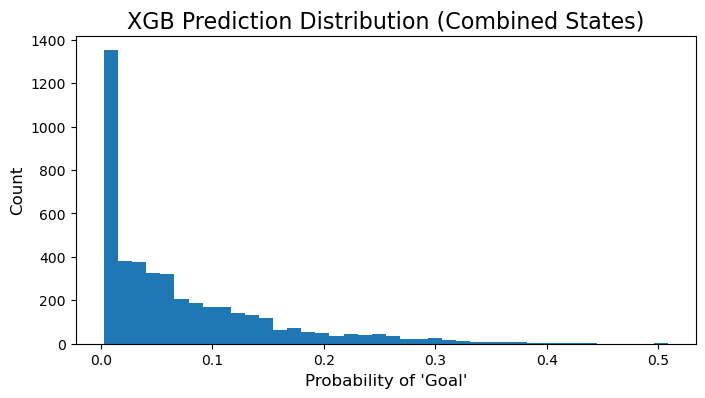

In [13]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(comb_test_pred_xgb, bins=40)
ax.set_title('XGB Prediction Distribution (Combined States)', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


## Separate Specific Game State Models

In [14]:
comb_state_preds_xgb = []
comb_state_loss_xgb = []
ind_state_preds_xgb = []
ind_state_loss_xgb = []
n_split_states = [10, 4, 4]
for i, (split_data, state, dumb_loss) in enumerate(zip(state_splits, state_names, state_dumb_losses)):
    # Extract the training and test data
    X_train, X_test, y_train, y_test = split_data
    
    # Initialize the model
    model_class = XGBClassifier(use_label_encoder=False, tree_method='hist', random_state=66)
    cv_split = StratifiedKFold(n_splits=n_split_states[i])
    
    # Train the model
    t_start = time()
    param_search = RandomizedSearchCV(model_class, xgb_params, n_iter=n_itr, scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
    param_search.fit(X_train, y_train)
    model = param_search.best_estimator_
    train_loss = -param_search.best_score_
    t_full = time() - t_start
    print(f'Took {timedelta(seconds=t_full)} to train the {state} XGBoost model')
    print(f"Trivial logloss for the {state} state: {dumb_loss:4.3f}")

    # Make predictions on the test set
    test_pred = model.predict_proba(X_test)[:, 1]
    test_loss = log_loss(y_test, test_pred)
    ind_state_preds_xgb.append(test_pred)
    ind_state_loss_xgb.append(test_loss)
    print(f"Training logloss on the {state} model: {train_loss:4.3f}")
    print(f"Test logloss on the {state} model: {test_loss:4.3f}\n")

    # Make predictions on the combined model
    comb_pred_state = comb_model_xgb.predict_proba(X_test)[:, 1]
    comb_state_preds_xgb.append(comb_pred_state)
    comb_state_loss_xgb.append(log_loss(y_test, comb_pred_state))


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [-0.21404908 -0.21313177 -0.21285178 -0.21192314 -0.21419946 -0.21578788
 -0.28467829 -0.21832474 -0.21456793 -0.27230754 -0.21320965 -0.2136124
 -0.21469253 -0.21228027 -0.2127126  -0.21367147 -0.21497293 -0.21787622
 -0.27555971 -0.21621845 -0.21909238 -0.21506648 -0.2714297  -0.25150113
 -0.21355777 -0.21319829 -0.21586328 -0.2214175  -0.21521257 -0.2174913
 -0.21398258 -0.2382972  -0.21263531 -0.22628835 -0.21234126 -0.40446532
 -0.21191908 -0.2139332  -0.21217439 -0.21329421 -0.28700622 -0.21300642
 -0.21364096 -0.22742627        -inf -0.22183283 -0.21261447 -0.21304164
 -0.21422286 -0.21195418 -0.214

Took 0:11:48.946829 to train the 4v5 XGBoost model
Trivial logloss for the 4v5 state: 0.255
Training logloss on the 4v5 model: 0.212
Test logloss on the 4v5 model: 0.217

Took 0:00:24.448635 to train the 3v5 XGBoost model
Trivial logloss for the 3v5 state: 0.232
Training logloss on the 3v5 model: 0.164
Test logloss on the 3v5 model: 0.252

Took 0:00:20.248614 to train the 3v4 XGBoost model
Trivial logloss for the 3v4 state: 0.277
Training logloss on the 3v4 model: 0.260
Test logloss on the 3v4 model: 0.156



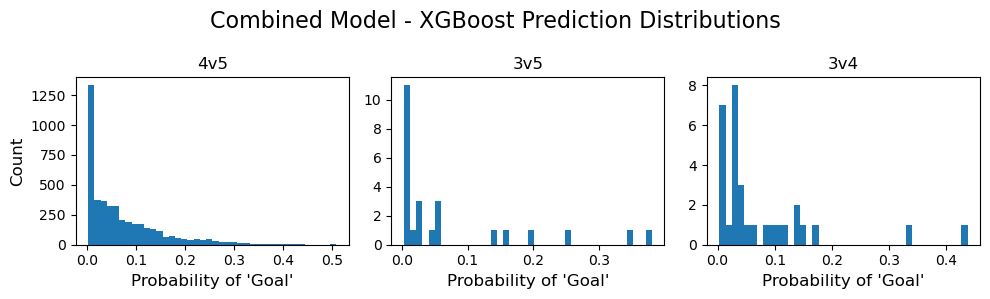

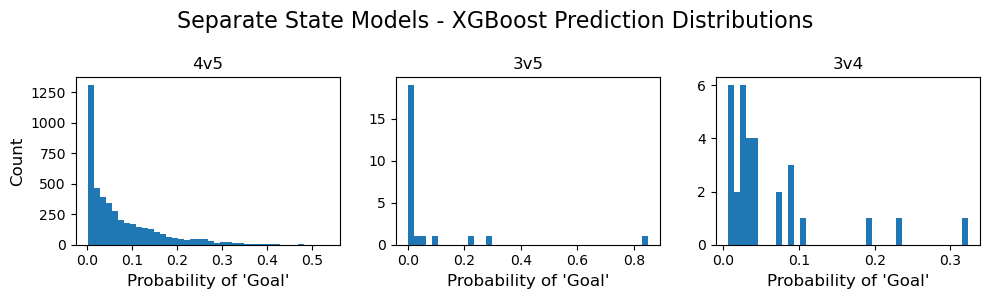

In [15]:
# Plot the individual state distributions

# Combined model (boolean state features)
fig, axes = plt.subplots(1, len(state_names), figsize=(10, 3))
for i, (pred, state) in enumerate(zip(comb_state_preds_xgb, state_names)):
    axes[i].hist(pred, bins=40)
    axes[i].set_title(f'{state}', fontsize=12)
    axes[i].set_xlabel("Probability of 'Goal'", fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
fig.suptitle('Combined Model - XGBoost Prediction Distributions', fontsize=16)
fig.tight_layout();

# Separate state models
fig, axes = plt.subplots(1, len(state_names), figsize=(10, 3))
for i, (pred, state) in enumerate(zip(ind_state_preds_xgb, state_names)):
    axes[i].hist(pred, bins=40)
    axes[i].set_title(f'{state}', fontsize=12)
    axes[i].set_xlabel("Probability of 'Goal'", fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
fig.suptitle('Separate State Models - XGBoost Prediction Distributions', fontsize=16)
fig.tight_layout();


## Neural Network Model Combining All Game States

In [16]:
# Define the neural network hyperparameters
learning_rate = 1e-4
batch_size = 16
n_epochs = 50
loss_fn = nn.BCEWithLogitsLoss()


Took 0:07:12.151684 to train the neural network
Trivial logloss for this problem: 0.277
Training logloss on the model: 0.217
Test logloss on the model: 0.225
Test accuracy on the model: 92.93%


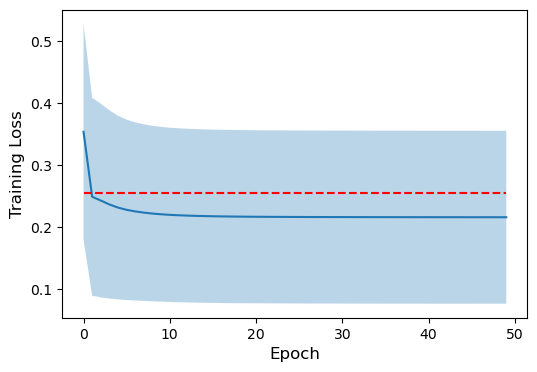

In [17]:
# Extract the training data
train_data_comb = CustomDataset(X_train_comb, y_train_comb)

# Initialize the model
comb_model_nn = RegressionNN(X_train_comb.shape[-1], 16, 1).to('cpu').float()
optimizer = optim.Adam(comb_model_nn.parameters(), lr=learning_rate, weight_decay=1e-3)

# Define the training and test data loaders
train_dataloader_comb = DataLoader(train_data_comb, batch_size=batch_size)

# Train the model
t_start = time()
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros_like(train_loss_avg)
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader_comb, comb_model_nn, loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the neural network')

# Plot the training loss
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.plot(np.arange(n_epochs), np.ones(n_epochs) * dumb_loss_all, 'r--', label='Dumb Logloss')
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)

# Make predictions on the test set
comb_train_pred_nn = sigmoid(comb_model_nn(Tensor(X_train_comb.astype(float)))).detach().numpy().squeeze()
comb_train_loss_nn = log_loss(y_train_comb, comb_train_pred_nn)
comb_test_pred_nn = sigmoid(comb_model_nn(Tensor(X_test_comb.astype(float)))).detach().numpy().squeeze()
comb_test_loss_nn = log_loss(y_test_comb, comb_test_pred_nn)
comb_test_acc_nn = 100 * (np.round(comb_test_pred_nn, 0) == y_test_comb).sum() / y_test_comb.size

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the model: {comb_train_loss_nn:4.3f}")
print(f"Test logloss on the model: {comb_test_loss_nn:4.3f}")
print(f"Test accuracy on the model: {comb_test_acc_nn:4.2f}%")


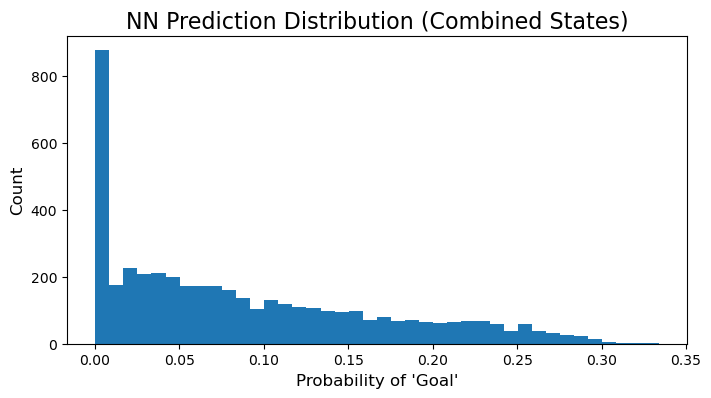

In [18]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(comb_test_pred_nn, bins=40)
ax.set_title('NN Prediction Distribution (Combined States)', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


## Neural Network Model of Separate Game States

Took 0:04:52.362732 to train the 4v5 XGBoost model
Trivial logloss for the 4v5 state: 0.255
Training logloss on the 4v5 model: 0.216
Test logloss on the 4v5 model: 0.224

Took 0:02:29.557880 to train the 3v5 XGBoost model
Trivial logloss for the 3v5 state: 0.232
Training logloss on the 3v5 model: 0.037
Test logloss on the 3v5 model: 0.522

Took 0:01:33.832745 to train the 3v4 XGBoost model
Trivial logloss for the 3v4 state: 0.277
Training logloss on the 3v4 model: 0.199
Test logloss on the 3v4 model: 0.207



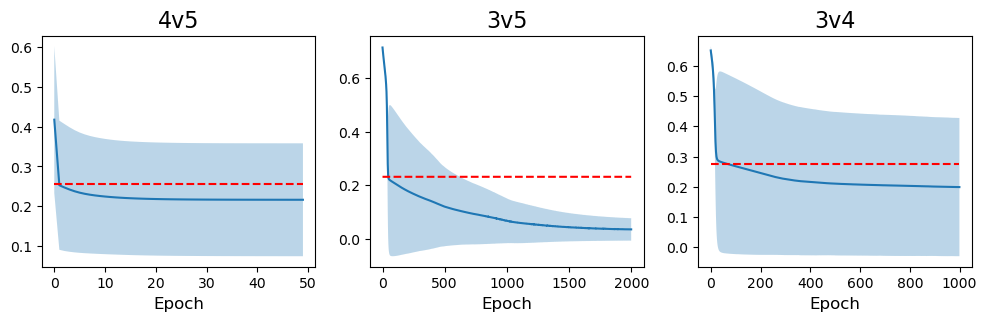

In [19]:
# Separate hyperparameters
batch_sizes = [16, 4, 4]
n_epoch_list = [50, 2000, 1000]
momentum_list = [1e-3, 1e-2, 1e-2]

comb_state_preds_nn = []
comb_state_loss_nn = []
ind_state_preds_nn = []
ind_state_loss_nn = []
fig, axes = plt.subplots(1, len(state_shots), figsize=(12, 3))
for i, (split_data, state, dumb_loss) in enumerate(zip(state_splits, state_names, state_dumb_losses)):
    # Split into training and test data
    X_train, X_test, y_train, y_test = split_data
    train_data = CustomDataset(X_train, y_train)
    train_dataloader = DataLoader(train_data, batch_size=batch_sizes[i])
    
    # Initialize the model
    model = RegressionNN(X_train.shape[-1], 16, 1).to('cpu').float()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=momentum_list[i])
    
    # Train the model
    t_start = time()
    train_loss_avg = np.zeros(n_epoch_list[i])
    train_loss_std = np.zeros_like(train_loss_avg)
    for t in range(n_epoch_list[i]):
        epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss_avg[t] = np.mean(epoch_loss)
        train_loss_std[t] = np.std(epoch_loss)
    t_full = time() - t_start
    print(f'Took {timedelta(seconds=t_full)} to train the {state} XGBoost model')
    print(f"Trivial logloss for the {state} state: {dumb_loss:4.3f}")
    
    # Plot the training loss
    axes[i].plot(np.arange(n_epoch_list[i]), train_loss_avg)
    axes[i].plot(np.arange(n_epoch_list[i]), np.ones(n_epoch_list[i]) * dumb_loss, 'r--', label='Dumb Logloss')
    axes[i].fill_between(np.arange(n_epoch_list[i]), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
    axes[i].set_xlabel('Epoch', fontsize=12)
    axes[i].set_title(f'{state}', fontsize=16)

    # Make predictions on the test set
    train_pred = sigmoid(model(Tensor(X_train.astype(float)))).detach().numpy().squeeze()
    train_loss = log_loss(y_train, train_pred)
    test_pred = sigmoid(model(Tensor(X_test.astype(float)))).detach().numpy().squeeze()
    test_loss = log_loss(y_test, test_pred)
    ind_state_preds_nn.append(test_pred)
    ind_state_loss_nn.append(test_loss)
    print(f"Training logloss on the {state} model: {train_loss:4.3f}")
    print(f"Test logloss on the {state} model: {test_loss:4.3f}\n")
    
    # Make predictions on the combined model
    comb_pred_state = sigmoid(comb_model_nn(Tensor(X_test.astype(float)))).detach().numpy().squeeze()
    comb_state_preds_nn.append(comb_pred_state)
    comb_state_loss_nn.append(log_loss(y_test, comb_pred_state))


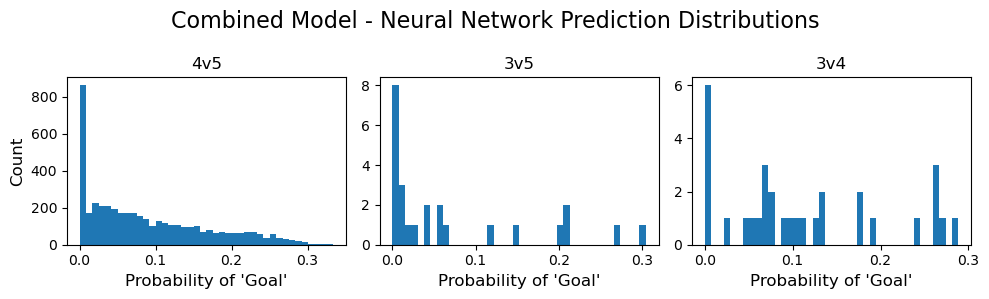

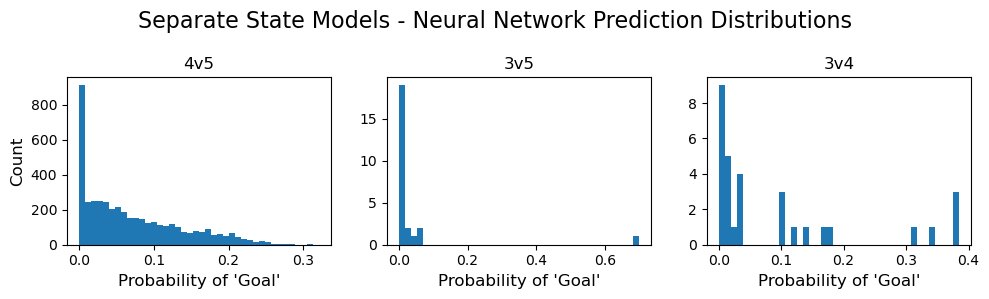

In [20]:
# Plot the individual state distributions

# Combined model (boolean state features)
fig, axes = plt.subplots(1, len(state_names), figsize=(10, 3))
for i, (pred, state) in enumerate(zip(comb_state_preds_nn, state_names)):
    axes[i].hist(pred, bins=40)
    axes[i].set_title(f'{state}', fontsize=12)
    axes[i].set_xlabel("Probability of 'Goal'", fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
fig.suptitle('Combined Model - Neural Network Prediction Distributions', fontsize=16)
fig.tight_layout();

# Separate state models
fig, axes = plt.subplots(1, len(state_names), figsize=(10, 3))
for i, (pred, state) in enumerate(zip(ind_state_preds_nn, state_names)):
    axes[i].hist(pred, bins=40)
    axes[i].set_title(f'{state}', fontsize=12)
    axes[i].set_xlabel("Probability of 'Goal'", fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
fig.suptitle('Separate State Models - Neural Network Prediction Distributions', fontsize=16)
fig.tight_layout();


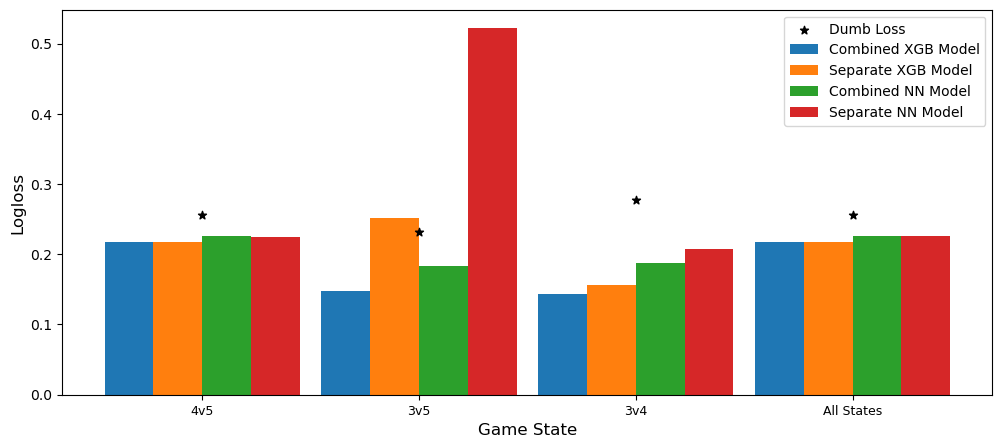

In [21]:
# Compare the model performances by logloss

# Combine individual models
all_state_preds_xgb = np.hstack(ind_state_preds_xgb)
all_state_loss_xgb = log_loss(y_test_comb, all_state_preds_xgb)
all_state_preds_nn = np.hstack(ind_state_preds_nn)
all_state_loss_nn = log_loss(y_test_comb, all_state_preds_nn)

# Plot the comparison
plt_losses = [comb_state_loss_xgb + [comb_test_loss_xgb],
              ind_state_loss_xgb + [all_state_loss_xgb],
              comb_state_loss_nn + [comb_test_loss_nn],
              ind_state_loss_nn + [all_state_loss_nn]]
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
width = 0.9 / len(plt_losses)
x0 = np.arange(len(state_names) + 1)
x_center = x0 + (len(plt_losses) - 1) * width / 2
model_types = ['Combined XGB', 'Separate XGB', 'Combined NN', 'Separate NN']
for i, (plt_loss, plt_lbl) in enumerate(zip(plt_losses, model_types)):
    xs = x0 + i * width
    ax.bar(xs, plt_loss, width=width, label=f'{plt_lbl} Model')
ax.scatter(x_center, state_dumb_losses + [dumb_loss_all], color='k', marker='*', label='Dumb Loss')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(x_center)
ax.set_xticklabels(state_names + ['All States'], fontsize=9)
ax.set_ylabel('Logloss', fontsize=12)
ax.legend(loc=1);


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:69: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


4v5 Game State
Combined XGB model calibration error: 0.0056
Separate XGB model calibration error: 0.0069
Combined NN model calibration error: 0.0073
Separate NN model calibration error: 0.0046

3v5 Game State
Combined XGB model calibration error: 0.0719
Separate XGB model calibration error: 0.1220
Combined NN model calibration error: 0.0850
Separate NN model calibration error: 0.0830

3v4 Game State
Combined XGB model calibration error: 0.0522
Separate XGB model calibration error: 0.0750
Combined NN model calibration error: 0.0506
Separate NN model calibration error: 0.0654



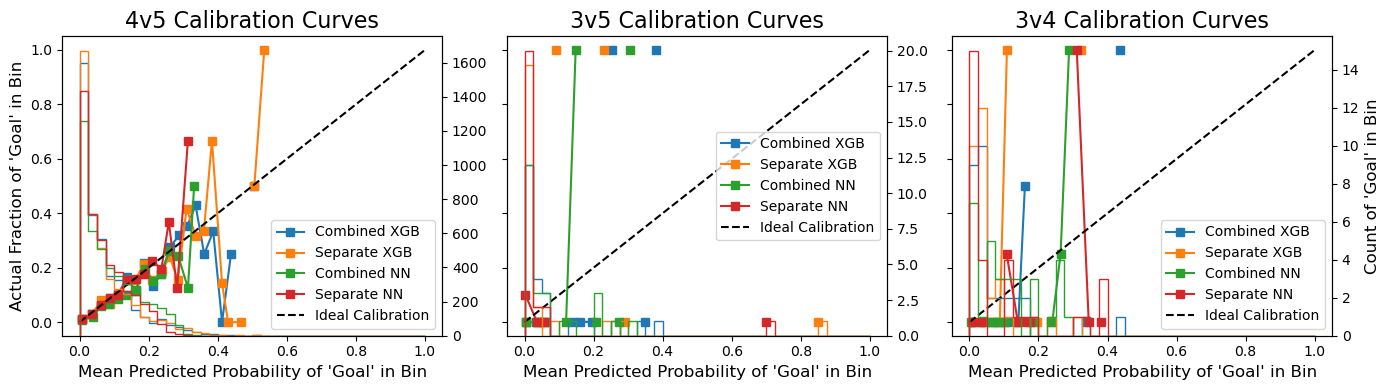

In [22]:
# Plot the calibration errors
cal_ys = []
cal_preds = []
for i, state in enumerate(state_names):
    cal_ys.append([state_test_ys[i], state_test_ys[i],
                   state_test_ys[i], state_test_ys[i]])
    cal_preds.append([comb_state_preds_xgb[i], ind_state_preds_xgb[i],
                      comb_state_preds_nn[i], ind_state_preds_nn[i]])

fig, axes = plt.subplots(1, len(state_names), figsize=(14, 4), sharey=True)
for i, (ys, preds, state) in enumerate(zip(cal_ys, cal_preds, state_names)):
    cal_objs = plot_calibration_curves(preds, ys, names=model_types, ax=axes[i], n_bins=40,
                                       return_err=True, avg_curve=False, class1='Goal',
                                       plt_ttl=f'{state} Calibration Curves')
    if i > 0:
        axes[i].set_ylabel('', fontsize=12)
    if i < 2:
        cal_objs[-2].set_ylabel('', fontsize=12)
    cal_errs = cal_objs[-1]
    print(f'{state} Game State\n'
          f'{model_types[0]} model calibration error: {cal_errs[0]:5.4f}\n'
          f'{model_types[1]} model calibration error: {cal_errs[1]:5.4f}\n'
          f'{model_types[2]} model calibration error: {cal_errs[2]:5.4f}\n'
          f'{model_types[3]} model calibration error: {cal_errs[3]:5.4f}\n')
fig.tight_layout();


# Conclusion and Model Choice

As expected, the combined models perform better for game states where there is less data, and neglibly worse for high frequency games states. Although, the combined models do tend to have greater calibration errors than the individual state models. 

The combined XGBoost model has a better logloss performance than all other model classes in every games state. It also has a comparable calibration error in each game state. Although the performance for the 3-on-5 and 3-on-4 models are better than trivial, due to the infrequency of these game states, it may be better to simply use the average shooting percentage as the expected goal probability. This would reduce the penalty kill model to exclusively the 4-on-5 state.

In a previous version of this notebook, the difference between game state booleans and number of player booleans was tested and found to be negligible. Therefore, to reduce the number of features, the number of player features may replace the game state booleans in the working models.
